In [1]:
####
## Celso Antonio Uliana Junior
## July 2 2020
####

import pandas as pd

#####
## Consuming and shaping the data to analysis
## Covid-19 numbers in Brazil by date
## Isolation percentage in Brazil by date
#####

data_raw_covid = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/covidBrasil.csv", sep = ";", decimal = ",")
data_raw_isolation = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/isolamento.csv", sep = ";", decimal = ",")
data_covid = data_raw_covid['Data'].values.copy()
data_covid = data_raw_covid.dropna().set_index("Data")
data_isolation = data_raw_isolation['Data'].values.copy()
data_isolation = data_raw_isolation.dropna().set_index("Data")

####
## Shaping a central pandas dataFrame for all our ML needs
####

data = data_covid
data['Taxa'] = data_isolation['Taxa'].values.copy()


In [2]:
from sklearn.preprocessing import MinMaxScaler

####
## normalizing values for both covid and isolation percentage 
## between range [0,1] using sklearn MinMaxScaler
####

covid_norm = data_covid["Casos"].values.copy()
covid_norm.shape = (len(covid_norm), 1)

isolation_norm = data_isolation["Taxa"].values.copy()
isolation_norm.shape = (len(isolation_norm), 1)

####
## Shaping the central dataFrame with normalized values
####
min_max_scaler = MinMaxScaler()

covid_norm = min_max_scaler.fit_transform(covid_norm)
isolation_norm = min_max_scaler.fit_transform(isolation_norm)

data["CasosNormalizados"] = covid_norm
data["TaxaNormalizadas"] = isolation_norm
data.head(20)

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas
Data,,,,
26/2/20,1,24.7,0.000018,0.000000
27/2/20,0,27.5,0.000000,0.074667
28/2/20,0,26.6,0.000000,0.050667
29/2/20,0,31.4,0.000000,0.178667
1/3/20,1,42,0.000018,0.461333
2/3/20,0,27.7,0.000000,0.080000
3/3/20,0,29,0.000000,0.114667
4/3/20,0,30.2,0.000000,0.146667
5/3/20,1,29.7,0.000018,0.133333


In [3]:
####
## Sliding window
####

df = pd.DataFrame()
window_size = 1
for i in range(0, window_size + 1):
    df['E{}'.format(i)] = data['CasosNormalizados'].shift(-i)
    if(i == window_size):
        for j in range(0, window_size + 1):
             df['E{}'.format(j + i + 1)] = data['TaxaNormalizadas'].shift(-j)
        df['E{}'.format(window_size * 2 + 2)] = data['CasosNormalizados'].shift(-window_size)
df = df.iloc[: -window_size]
print(df)

               E0        E1        E2        E3        E4
Data                                                     
26/2/20  0.000018  0.000000  0.000000  0.074667  0.000000
27/2/20  0.000000  0.000000  0.074667  0.050667  0.000000
28/2/20  0.000000  0.000000  0.050667  0.178667  0.000000
29/2/20  0.000000  0.000018  0.178667  0.461333  0.000018
1/3/20   0.000018  0.000000  0.461333  0.080000  0.000000
...           ...       ...       ...       ...       ...
16/6/20  0.376970  0.637527  0.384000  0.336000  0.637527
17/6/20  0.637527  0.587683  0.336000  0.368000  0.587683
18/6/20  0.587683  0.415640  0.368000  0.266667  0.415640
19/6/20  0.415640  1.000000  0.266667  0.384000  1.000000
20/6/20  1.000000  0.632926  0.384000  0.602667  0.632926

[116 rows x 5 columns]


In [4]:
####
## Manipulating the data to split into X(a window size of values)
## and target, or Y, the value X "produces"
####

arr = df.values

X = arr[:, : -1]
target = arr[:, -1]
#print(X)
#print(target)

In [5]:
####
## Config of the regressors and cross val cross val leave one out
####

from sklearn import metrics
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

mlp = MLPRegressor(
    hidden_layer_sizes = (50,), alpha = 0.001,
    learning_rate_init = 0.01, max_iter = 1000,
    random_state = 9, tol = 0.0001, verbose = True)
svr = SVR(kernel = 'linear', C = 0.25, epsilon = 0.01, verbose = True, max_iter = 1000)

full_predict_mlp = cross_val_predict(mlp, X, target, cv = loo)
full_predict_svr = cross_val_predict(svr, X, target, cv = loo)

Iteration 1, loss = 0.06799594
Iteration 2, loss = 0.03454402
Iteration 3, loss = 0.01817950
Iteration 4, loss = 0.01613405
Iteration 5, loss = 0.02032831
Iteration 6, loss = 0.02227652
Iteration 7, loss = 0.01967983
Iteration 8, loss = 0.01436826
Iteration 9, loss = 0.00890014
Iteration 10, loss = 0.00493624
Iteration 11, loss = 0.00313237
Iteration 12, loss = 0.00316933
Iteration 13, loss = 0.00414376
Iteration 14, loss = 0.00510754
Iteration 15, loss = 0.00542522
Iteration 16, loss = 0.00497026
Iteration 17, loss = 0.00407825
Iteration 18, loss = 0.00324354
Iteration 19, loss = 0.00288300
Iteration 20, loss = 0.00307314
Iteration 21, loss = 0.00356206
Iteration 22, loss = 0.00393049
Iteration 23, loss = 0.00390457
Iteration 24, loss = 0.00346868
Iteration 25, loss = 0.00281193
Iteration 26, loss = 0.00217973
Iteration 27, loss = 0.00174951
Iteration 28, loss = 0.00157112
Iteration 29, loss = 0.00158704
Iteration 30, loss = 0.00167944
Iteration 31, loss = 0.00173816
Iteration 32, los

Iteration 1, loss = 0.06798818
Iteration 2, loss = 0.03455303
Iteration 3, loss = 0.01819991
Iteration 4, loss = 0.01615803
Iteration 5, loss = 0.02035275
Iteration 6, loss = 0.02229756
Iteration 7, loss = 0.01969731
Iteration 8, loss = 0.01438490
Iteration 9, loss = 0.00891780
Iteration 10, loss = 0.00495647
Iteration 11, loss = 0.00315469
Iteration 12, loss = 0.00319197
Iteration 13, loss = 0.00416502
Iteration 14, loss = 0.00512625
Iteration 15, loss = 0.00544075
Iteration 16, loss = 0.00498215
Iteration 17, loss = 0.00408714
Iteration 18, loss = 0.00325036
Iteration 19, loss = 0.00288829
Iteration 20, loss = 0.00307838
Iteration 21, loss = 0.00356729
Iteration 22, loss = 0.00393547
Iteration 23, loss = 0.00390904
Iteration 24, loss = 0.00347194
Iteration 25, loss = 0.00281399
Iteration 26, loss = 0.00218084
Iteration 27, loss = 0.00175066
Iteration 28, loss = 0.00157251
Iteration 29, loss = 0.00158888
Iteration 30, loss = 0.00168184
Iteration 31, loss = 0.00174042
Iteration 32, los

Iteration 38, loss = 0.00128005
Iteration 39, loss = 0.00134808
Iteration 40, loss = 0.00138330
Iteration 41, loss = 0.00136262
Iteration 42, loss = 0.00128934
Iteration 43, loss = 0.00118782
Iteration 44, loss = 0.00109017
Iteration 45, loss = 0.00102033
Iteration 46, loss = 0.00098498
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06799131
Iteration 2, loss = 0.03455081
Iteration 3, loss = 0.01819390
Iteration 4, loss = 0.01615015
Iteration 5, loss = 0.02034168
Iteration 6, loss = 0.02228923
Iteration 7, loss = 0.01969157
Iteration 8, loss = 0.01438059
Iteration 9, loss = 0.00891356
Iteration 10, loss = 0.00495138
Iteration 11, loss = 0.00314819
Iteration 12, loss = 0.00318441
Iteration 13, loss = 0.00415724
Iteration 14, loss = 0.00511927
Iteration 15, loss = 0.00543552
Iteration 16, loss = 0.00497880
Iteration 17, loss = 0.00408540
Iteration 18, loss = 0.00324949
Iteration 19, loss = 0.00288710
Iteration 20, loss = 0.

Iteration 45, loss = 0.00101834
Iteration 46, loss = 0.00098302
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06797748
Iteration 2, loss = 0.03455597
Iteration 3, loss = 0.01820868
Iteration 4, loss = 0.01616502
Iteration 5, loss = 0.02035872
Iteration 6, loss = 0.02230754
Iteration 7, loss = 0.01970982
Iteration 8, loss = 0.01439810
Iteration 9, loss = 0.00893174
Iteration 10, loss = 0.00497169
Iteration 11, loss = 0.00317352
Iteration 12, loss = 0.00321400
Iteration 13, loss = 0.00418800
Iteration 14, loss = 0.00514675
Iteration 15, loss = 0.00545436
Iteration 16, loss = 0.00499015
Iteration 17, loss = 0.00408931
Iteration 18, loss = 0.00324557
Iteration 19, loss = 0.00287903
Iteration 20, loss = 0.00306580
Iteration 21, loss = 0.00355481
Iteration 22, loss = 0.00392589
Iteration 23, loss = 0.00390422
Iteration 24, loss = 0.00347077
Iteration 25, loss = 0.00281314
Iteration 26, loss = 0.00217814
Iteration 27, loss = 0.

Iteration 1, loss = 0.06787284
Iteration 2, loss = 0.03455670
Iteration 3, loss = 0.01811689
Iteration 4, loss = 0.01591444
Iteration 5, loss = 0.02011426
Iteration 6, loss = 0.02220865
Iteration 7, loss = 0.01976279
Iteration 8, loss = 0.01454032
Iteration 9, loss = 0.00908896
Iteration 10, loss = 0.00509130
Iteration 11, loss = 0.00322804
Iteration 12, loss = 0.00319969
Iteration 13, loss = 0.00412698
Iteration 14, loss = 0.00507226
Iteration 15, loss = 0.00540812
Iteration 16, loss = 0.00498610
Iteration 17, loss = 0.00410488
Iteration 18, loss = 0.00324214
Iteration 19, loss = 0.00282235
Iteration 20, loss = 0.00296556
Iteration 21, loss = 0.00344628
Iteration 22, loss = 0.00385976
Iteration 23, loss = 0.00390014
Iteration 24, loss = 0.00351816
Iteration 25, loss = 0.00288305
Iteration 26, loss = 0.00224023
Iteration 27, loss = 0.00177857
Iteration 28, loss = 0.00156755
Iteration 29, loss = 0.00156328
Iteration 30, loss = 0.00165115
Iteration 31, loss = 0.00171855
Iteration 32, los

Iteration 11, loss = 0.00320266
Iteration 12, loss = 0.00319287
Iteration 13, loss = 0.00414733
Iteration 14, loss = 0.00511723
Iteration 15, loss = 0.00544988
Iteration 16, loss = 0.00499772
Iteration 17, loss = 0.00408830
Iteration 18, loss = 0.00321706
Iteration 19, loss = 0.00281035
Iteration 20, loss = 0.00297176
Iteration 21, loss = 0.00345738
Iteration 22, loss = 0.00385780
Iteration 23, loss = 0.00387579
Iteration 24, loss = 0.00347538
Iteration 25, loss = 0.00283385
Iteration 26, loss = 0.00219801
Iteration 27, loss = 0.00175102
Iteration 28, loss = 0.00155683
Iteration 29, loss = 0.00156490
Iteration 30, loss = 0.00165811
Iteration 31, loss = 0.00172451
Iteration 32, loss = 0.00170301
Iteration 33, loss = 0.00159185
Iteration 34, loss = 0.00143320
Iteration 35, loss = 0.00128890
Iteration 36, loss = 0.00120615
Iteration 37, loss = 0.00120062
Iteration 38, loss = 0.00125293
Iteration 39, loss = 0.00132168
Iteration 40, loss = 0.00136323
Iteration 41, loss = 0.00135108
Iteratio

Iteration 41, loss = 0.00134466
Iteration 42, loss = 0.00126453
Iteration 43, loss = 0.00116249
Iteration 44, loss = 0.00107222
Iteration 45, loss = 0.00101472
Iteration 46, loss = 0.00099152
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06786679
Iteration 2, loss = 0.03455535
Iteration 3, loss = 0.01817109
Iteration 4, loss = 0.01602535
Iteration 5, loss = 0.02020828
Iteration 6, loss = 0.02224009
Iteration 7, loss = 0.01973747
Iteration 8, loss = 0.01448470
Iteration 9, loss = 0.00902656
Iteration 10, loss = 0.00503640
Iteration 11, loss = 0.00319498
Iteration 12, loss = 0.00319739
Iteration 13, loss = 0.00415841
Iteration 14, loss = 0.00512974
Iteration 15, loss = 0.00545700
Iteration 16, loss = 0.00499820
Iteration 17, loss = 0.00408561
Iteration 18, loss = 0.00321878
Iteration 19, loss = 0.00282065
Iteration 20, loss = 0.00298857
Iteration 21, loss = 0.00347482
Iteration 22, loss = 0.00386794
Iteration 23, loss = 0.

Iteration 28, loss = 0.00156138
Iteration 29, loss = 0.00158809
Iteration 30, loss = 0.00168417
Iteration 31, loss = 0.00173931
Iteration 32, loss = 0.00169737
Iteration 33, loss = 0.00156483
Iteration 34, loss = 0.00139437
Iteration 35, loss = 0.00125210
Iteration 36, loss = 0.00118433
Iteration 37, loss = 0.00119900
Iteration 38, loss = 0.00126743
Iteration 39, loss = 0.00134112
Iteration 40, loss = 0.00137525
Iteration 41, loss = 0.00134834
Iteration 42, loss = 0.00126896
Iteration 43, loss = 0.00116681
Iteration 44, loss = 0.00107570
Iteration 45, loss = 0.00101700
Iteration 46, loss = 0.00099247
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06784925
Iteration 2, loss = 0.03455064
Iteration 3, loss = 0.01819826
Iteration 4, loss = 0.01607737
Iteration 5, loss = 0.02025047
Iteration 6, loss = 0.02225751
Iteration 7, loss = 0.01973294
Iteration 8, loss = 0.01446842
Iteration 9, loss = 0.00901119
Iteration 10, loss = 0.

Iteration 36, loss = 0.00118821
Iteration 37, loss = 0.00120337
Iteration 38, loss = 0.00127160
Iteration 39, loss = 0.00134422
Iteration 40, loss = 0.00137701
Iteration 41, loss = 0.00134912
Iteration 42, loss = 0.00126923
Iteration 43, loss = 0.00116686
Iteration 44, loss = 0.00107560
Iteration 45, loss = 0.00101652
Iteration 46, loss = 0.00099171
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06783153
Iteration 2, loss = 0.03454766
Iteration 3, loss = 0.01820261
Iteration 4, loss = 0.01608228
Iteration 5, loss = 0.02024706
Iteration 6, loss = 0.02224201
Iteration 7, loss = 0.01971374
Iteration 8, loss = 0.01444970
Iteration 9, loss = 0.00899634
Iteration 10, loss = 0.00502044
Iteration 11, loss = 0.00319148
Iteration 12, loss = 0.00320177
Iteration 13, loss = 0.00415926
Iteration 14, loss = 0.00511905
Iteration 15, loss = 0.00544189
Iteration 16, loss = 0.00499047
Iteration 17, loss = 0.00409070
Iteration 18, loss = 0.

Iteration 29, loss = 0.00158284
Iteration 30, loss = 0.00167899
Iteration 31, loss = 0.00173444
Iteration 32, loss = 0.00169516
Iteration 33, loss = 0.00156659
Iteration 34, loss = 0.00140101
Iteration 35, loss = 0.00126302
Iteration 36, loss = 0.00119678
Iteration 37, loss = 0.00121004
Iteration 38, loss = 0.00127542
Iteration 39, loss = 0.00134676
Iteration 40, loss = 0.00138008
Iteration 41, loss = 0.00135393
Iteration 42, loss = 0.00127547
Iteration 43, loss = 0.00117294
Iteration 44, loss = 0.00107939
Iteration 45, loss = 0.00101688
Iteration 46, loss = 0.00098875
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06768307
Iteration 2, loss = 0.03449014
Iteration 3, loss = 0.01824319
Iteration 4, loss = 0.01618090
Iteration 5, loss = 0.02030008
Iteration 6, loss = 0.02220896
Iteration 7, loss = 0.01962466
Iteration 8, loss = 0.01434289
Iteration 9, loss = 0.00890010
Iteration 10, loss = 0.00495378
Iteration 11, loss = 0.

Iteration 41, loss = 0.00135095
Iteration 42, loss = 0.00126951
Iteration 43, loss = 0.00116642
Iteration 44, loss = 0.00107482
Iteration 45, loss = 0.00101564
Iteration 46, loss = 0.00099075
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06774635
Iteration 2, loss = 0.03451030
Iteration 3, loss = 0.01823945
Iteration 4, loss = 0.01616523
Iteration 5, loss = 0.02030679
Iteration 6, loss = 0.02223899
Iteration 7, loss = 0.01965756
Iteration 8, loss = 0.01437079
Iteration 9, loss = 0.00892340
Iteration 10, loss = 0.00497009
Iteration 11, loss = 0.00316865
Iteration 12, loss = 0.00320101
Iteration 13, loss = 0.00416866
Iteration 14, loss = 0.00512457
Iteration 15, loss = 0.00543369
Iteration 16, loss = 0.00497324
Iteration 17, loss = 0.00407516
Iteration 18, loss = 0.00323098
Iteration 19, loss = 0.00286337
Iteration 20, loss = 0.00305240
Iteration 21, loss = 0.00353972
Iteration 22, loss = 0.00391052
Iteration 23, loss = 0.

Iteration 12, loss = 0.00319408
Iteration 13, loss = 0.00417341
Iteration 14, loss = 0.00513030
Iteration 15, loss = 0.00543141
Iteration 16, loss = 0.00497082
Iteration 17, loss = 0.00407655
Iteration 18, loss = 0.00324445
Iteration 19, loss = 0.00288798
Iteration 20, loss = 0.00308182
Iteration 21, loss = 0.00356238
Iteration 22, loss = 0.00392204
Iteration 23, loss = 0.00388481
Iteration 24, loss = 0.00343638
Iteration 25, loss = 0.00277066
Iteration 26, loss = 0.00213816
Iteration 27, loss = 0.00171339
Iteration 28, loss = 0.00154556
Iteration 29, loss = 0.00157083
Iteration 30, loss = 0.00166653
Iteration 31, loss = 0.00172458
Iteration 32, loss = 0.00168859
Iteration 33, loss = 0.00156259
Iteration 34, loss = 0.00140092
Iteration 35, loss = 0.00126597
Iteration 36, loss = 0.00120087
Iteration 37, loss = 0.00121403
Iteration 38, loss = 0.00127855
Iteration 39, loss = 0.00134840
Iteration 40, loss = 0.00137984
Iteration 41, loss = 0.00135175
Iteration 42, loss = 0.00127175
Iteratio

Iteration 39, loss = 0.00134773
Iteration 40, loss = 0.00137294
Iteration 41, loss = 0.00133875
Iteration 42, loss = 0.00125554
Iteration 43, loss = 0.00115314
Iteration 44, loss = 0.00106317
Iteration 45, loss = 0.00100507
Iteration 46, loss = 0.00097978
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06759561
Iteration 2, loss = 0.03446095
Iteration 3, loss = 0.01824353
Iteration 4, loss = 0.01617401
Iteration 5, loss = 0.02027212
Iteration 6, loss = 0.02215751
Iteration 7, loss = 0.01956473
Iteration 8, loss = 0.01428457
Iteration 9, loss = 0.00885062
Iteration 10, loss = 0.00491561
Iteration 11, loss = 0.00313007
Iteration 12, loss = 0.00317659
Iteration 13, loss = 0.00415326
Iteration 14, loss = 0.00511328
Iteration 15, loss = 0.00542540
Iteration 16, loss = 0.00497033
Iteration 17, loss = 0.00407648
Iteration 18, loss = 0.00324033
Iteration 19, loss = 0.00287475
Iteration 20, loss = 0.00306142
Iteration 21, loss = 0.

Iteration 36, loss = 0.00119477
Iteration 37, loss = 0.00121565
Iteration 38, loss = 0.00128296
Iteration 39, loss = 0.00134958
Iteration 40, loss = 0.00137410
Iteration 41, loss = 0.00133916
Iteration 42, loss = 0.00125541
Iteration 43, loss = 0.00115236
Iteration 44, loss = 0.00106220
Iteration 45, loss = 0.00100458
Iteration 46, loss = 0.00097984
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06717157
Iteration 2, loss = 0.03423050
Iteration 3, loss = 0.01818637
Iteration 4, loss = 0.01621800
Iteration 5, loss = 0.02028007
Iteration 6, loss = 0.02206047
Iteration 7, loss = 0.01938881
Iteration 8, loss = 0.01409779
Iteration 9, loss = 0.00870209
Iteration 10, loss = 0.00482630
Iteration 11, loss = 0.00310067
Iteration 12, loss = 0.00318739
Iteration 13, loss = 0.00418127
Iteration 14, loss = 0.00513310
Iteration 15, loss = 0.00541888
Iteration 16, loss = 0.00494533
Iteration 17, loss = 0.00405232
Iteration 18, loss = 0.

Iteration 36, loss = 0.00117171
Iteration 37, loss = 0.00119888
Iteration 38, loss = 0.00126748
Iteration 39, loss = 0.00133060
Iteration 40, loss = 0.00134960
Iteration 41, loss = 0.00130955
Iteration 42, loss = 0.00122337
Iteration 43, loss = 0.00112144
Iteration 44, loss = 0.00103497
Iteration 45, loss = 0.00098175
Iteration 46, loss = 0.00096025
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06715224
Iteration 2, loss = 0.03419957
Iteration 3, loss = 0.01817355
Iteration 4, loss = 0.01622811
Iteration 5, loss = 0.02029375
Iteration 6, loss = 0.02207637
Iteration 7, loss = 0.01940012
Iteration 8, loss = 0.01409108
Iteration 9, loss = 0.00866468
Iteration 10, loss = 0.00476009
Iteration 11, loss = 0.00300767
Iteration 12, loss = 0.00307231
Iteration 13, loss = 0.00404278
Iteration 14, loss = 0.00497143
Iteration 15, loss = 0.00524713
Iteration 16, loss = 0.00476320
Iteration 17, loss = 0.00387001
Iteration 18, loss = 0.

Iteration 10, loss = 0.00475146
Iteration 11, loss = 0.00314069
Iteration 12, loss = 0.00329469
Iteration 13, loss = 0.00427952
Iteration 14, loss = 0.00516339
Iteration 15, loss = 0.00536760
Iteration 16, loss = 0.00482146
Iteration 17, loss = 0.00390048
Iteration 18, loss = 0.00311347
Iteration 19, loss = 0.00284002
Iteration 20, loss = 0.00311486
Iteration 21, loss = 0.00362280
Iteration 22, loss = 0.00394868
Iteration 23, loss = 0.00384572
Iteration 24, loss = 0.00334497
Iteration 25, loss = 0.00266726
Iteration 26, loss = 0.00206371
Iteration 27, loss = 0.00168932
Iteration 28, loss = 0.00156683
Iteration 29, loss = 0.00161448
Iteration 30, loss = 0.00170376
Iteration 31, loss = 0.00173445
Iteration 32, loss = 0.00166556
Iteration 33, loss = 0.00151784
Iteration 34, loss = 0.00134973
Iteration 35, loss = 0.00122396
Iteration 36, loss = 0.00117806
Iteration 37, loss = 0.00120949
Iteration 38, loss = 0.00128290
Iteration 39, loss = 0.00134886
Iteration 40, loss = 0.00136734
Iteratio

Iteration 37, loss = 0.00120483
Iteration 38, loss = 0.00127755
Iteration 39, loss = 0.00134412
Iteration 40, loss = 0.00136423
Iteration 41, loss = 0.00132362
Iteration 42, loss = 0.00123645
Iteration 43, loss = 0.00113402
Iteration 44, loss = 0.00104789
Iteration 45, loss = 0.00099597
Iteration 46, loss = 0.00097620
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.06645779
Iteration 2, loss = 0.03371394
Iteration 3, loss = 0.01788762
Iteration 4, loss = 0.01612478
Iteration 5, loss = 0.02023412
Iteration 6, loss = 0.02195577
Iteration 7, loss = 0.01922014
Iteration 8, loss = 0.01392754
Iteration 9, loss = 0.00858042
Iteration 10, loss = 0.00477782
Iteration 11, loss = 0.00311751
Iteration 12, loss = 0.00323279
Iteration 13, loss = 0.00421256
Iteration 14, loss = 0.00512475
Iteration 15, loss = 0.00537145
Iteration 16, loss = 0.00486787
Iteration 17, loss = 0.00397397
Iteration 18, loss = 0.00318570
Iteration 19, loss = 0.

Iteration 13, loss = 0.00415715
Iteration 14, loss = 0.00505940
Iteration 15, loss = 0.00529886
Iteration 16, loss = 0.00478497
Iteration 17, loss = 0.00387856
Iteration 18, loss = 0.00308613
Iteration 19, loss = 0.00279966
Iteration 20, loss = 0.00306448
Iteration 21, loss = 0.00357767
Iteration 22, loss = 0.00392060
Iteration 23, loss = 0.00383520
Iteration 24, loss = 0.00334365
Iteration 25, loss = 0.00266562
Iteration 26, loss = 0.00205263
Iteration 27, loss = 0.00166516
Iteration 28, loss = 0.00153107
Iteration 29, loss = 0.00157290
Iteration 30, loss = 0.00166239
Iteration 31, loss = 0.00169674
Iteration 32, loss = 0.00163222
Iteration 33, loss = 0.00148825
Iteration 34, loss = 0.00132139
Iteration 35, loss = 0.00119404
Iteration 36, loss = 0.00114538
Iteration 37, loss = 0.00117534
Iteration 38, loss = 0.00124964
Iteration 39, loss = 0.00131911
Iteration 40, loss = 0.00134297
Iteration 41, loss = 0.00130575
Iteration 42, loss = 0.00122066
Iteration 43, loss = 0.00111904
Iteratio

In [6]:
####
## Printing some metrics of the regressors
####

print('Mean Squared Error in MLP: %s' %(metrics.mean_squared_error(target, full_predict_mlp)))
print('Mean Squared Error in SVR: %s' %(metrics.mean_squared_error(target, full_predict_svr)))

r_squared_mlp = metrics.r2_score(target, full_predict_mlp)
r_squared_svr = metrics.r2_score(target, full_predict_svr)

print('R² score in MLP: %s' %(r_squared_mlp))
print('R² score in SVR: %s' %(r_squared_svr))

adjusted_r_squared_mlp = 1 - (1 - r_squared_mlp) * (len(target) - 1) / (len(target) - X.shape[1] - 1)
adjusted_r_squared_svr = 1 - (1 - r_squared_svr) * (len(target) - 1) / (len(target) - X.shape[1] - 1)

print('adjusted R² score in MLP: %s' %(adjusted_r_squared_mlp))
print('adjusted R² score in SVR: %s' %(adjusted_r_squared_svr))

Mean Squared Error in MLP: 0.002362236727882373
Mean Squared Error in SVR: 0.00019982562195105142
R² score in MLP: 0.9444229173631248
R² score in SVR: 0.9952986400672492
adjusted R² score in MLP: 0.9424201396104446
adjusted R² score in SVR: 0.9951292216912943


In [7]:
####
## Filling lists with NaN so the len is the same across all lists 
## so that a graph can be generated
####

import numpy as np

values_to_add = list()
for i in range(0, window_size):
    values_to_add.append(float('NaN'))
    
full_predict_svr = np.insert(full_predict_svr, 0, values_to_add)
full_predict_svr.shape = (len(full_predict_svr), 1)
    
full_predict_mlp = np.insert(full_predict_mlp, 0, values_to_add)
full_predict_mlp.shape = (len(full_predict_mlp), 1)

print(full_predict_svr.shape)
print(full_predict_mlp.shape)

(117, 1)
(117, 1)


In [8]:
####
## Adding the data to plot 
####

data['Predict_mlp'] = full_predict_mlp
data['Predict_svr'] = full_predict_svr
data

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas,Predict_mlp,Predict_svr
Data,,,,,,
26/2/20,1,24.7,0.000018,0.000000,NaN,NaN
27/2/20,0,27.5,0.000000,0.074667,0.026539,0.009819
28/2/20,0,26.6,0.000000,0.050667,0.025051,0.008534
29/2/20,0,31.4,0.000000,0.178667,0.012591,0.010370
1/3/20,1,42,0.000018,0.461333,-0.000368,0.011176
...,...,...,...,...,...,...
17/6/20,34918,37.3,0.637527,0.336000,0.522379,0.597666
18/6/20,32188,38.5,0.587683,0.368000,0.585322,0.584533
19/6/20,22765,34.7,0.415640,0.266667,0.492881,0.429907


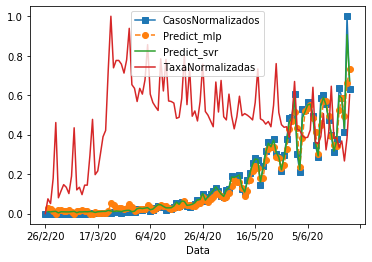

In [9]:
####
## Ploting the graph
####

import matplotlib.pyplot as plt
data.plot(y=['CasosNormalizados', 'Predict_mlp', 'Predict_svr', 'TaxaNormalizadas'], style=['-s', '--o'])
#data.plot(y=['CasosNormalizados', 'Predict_mlp', 'Predict_svr',], style=['-s', '--o'])
plt.show()

In [10]:
####
## Calculating Pearson correlation 
####

import numpy
from scipy.stats import pearsonr
arrTaxa = data['TaxaNormalizadas'].values.copy()
arrCasos = data['CasosNormalizados'].values.copy()
print(pearsonr(arrTaxa, arrCasos))

(-0.03892879028152567, 0.6768859337467233)
